In [713]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.linalg import block_diag
from scipy import linalg
import control
import matplotlib.colors as colors
from matplotlib import style
from matplotlib.patches import Rectangle
from numpy.linalg import matrix_power
import cvxpy as cp

In [714]:
# finding the value of Gamma_k, a helper
def Gamma(F,G,K,k):
    Gamma_k = np.zeros(F.shape)
    for h in range(k+1):
        Gamma_k += matrix_power(F - G @ K, h) @ G @ K @ matrix_power(F - G @ K, k-h)
    return -Gamma_k

In [715]:
# finding the value of x_0' at any k
def xk_prime(F_K,k,x_0_prime):
    xk_prime = matrix_power(F_K,k)@x_0_prime
    return xk_prime
    # finding the mean value of x_0'' at any k
    
def bar_xk_Dprime(F_K,k,x_0_Dprime,x_0_prime):
    bar_x_Dprime = matrix_power(F_K,k)@x_0_Dprime + Gamma(F,G,K,k-1)@x_0_prime
    return bar_x_Dprime

In [716]:
# calculating constant values \mathcal A1, A2 of J_c(x_0')
def A1_and_A2(F,G,K,Q,R,N):
    A1 = Gamma(F,G,K,N-1).T @ Q @ Gamma(F,G,K,N-1)
    F_K = F - G @ K
    A2 = matrix_power(F_K,N).T @ Q @ Gamma(F,G,K,N-1) 
    for k in range(N):
        A1 += Gamma(F,G,K,k-1).T @ Q @ Gamma(F,G,K,k-1) + (matrix_power(F_K,k) + 
                Gamma(F,G,K,k-1)).T @ K.T @ R @ K @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1))
        A2 += matrix_power(F_K,k).T @ (Q @ Gamma(F,G,K,k-1) + K.T @ R @ K @ (matrix_power(F_K,k) + Gamma(F,G,K,k-1)))
    return A1/N, A2/N


Need a function to calculate the sigmas. Need a function to calculate the P, and a function
to return the quadratic constraint.

In [717]:
def Constraints(F,G,K,T,S,Sigma_x,Sigma_u,x0_bar,x0_prime,uBar,xBar,N,epsilon):
    constraints = [-S @ K @ x0_prime <= uBar + S @ K @ x0_bar]
    
    for k in range(1,N+1):
        constraints += [T @ Gamma(F,G,K,k-1) @ x0_prime <= xBar-np.sqrt((1-epsilon)/epsilon)*\
            np.sqrt(np.diag(T@Sigma_x@T.T).reshape(1,1))-T@matrix_power(F-G@K,k)@x0_bar]
        if (k<N):
            constraints += [-S @ K @ (Gamma(F,G,K,k-1) + matrix_power(F-G@K,k)) @ x0_prime <= 
                            uBar-np.sqrt((1-epsilon)/epsilon)*\
                np.sqrt(np.diag(S@Sigma_u@S.T).reshape(1,1))+S@K@matrix_power(F-G@K,k)@x0_bar]
    return constraints
 
def terminal_constraints(F,G,K,N,P):
    n = F.shape[0]
    F_K = F - G @ K
    P11 = P[0:n,0:n]
    P22 = P[n:2*n,n:2*n]
    P12 = P[0:n,n:2*n]
    
    I1 = Gamma(F,G,K,N-1).T @ P11 @ Gamma(F,G,K,N-1)
    I2 = 2 * matrix_power(F_K.T, N) @ (P11 + P12.T) @ Gamma(F,G,K,N-1)
    I3 = matrix_power(F_K.T, N) * (P11 + 2 * P12.T + P22) @ matrix_power(F_K, N)
    return I1, I2, I3


In [718]:
def big_covariance_Sigma(F,G,K,H,L,Sigma_v,Sigma_w):
    Phi1 = np.concatenate((F - L @ H, np.zeros(F.shape)), axis=1)
    Phi2 = np.concatenate((L @ H, F - G @ K), axis=1)
    Phi = np.concatenate((Phi1,Phi2), axis=0)
    
    Psi1 = np.concatenate((np.eye(F.shape[0]), -L), axis=1)
    Psi2 = np.concatenate((np.zeros(F.shape), L), axis=1)
    Psi = np.concatenate((Psi1,Psi2), axis=0)
    
    Omega = block_diag(Sigma_w,Sigma_v)
    Sigma = linalg.solve_discrete_lyapunov(Phi, Psi @ Omega @ Psi.T)
    return Sigma
    
def lyapunov_matrix_P(F,G,K,Q0):
    A1 = np.concatenate((F - G @ K, -G @ K), axis=1)
    A2 = np.concatenate((np.zeros(F.shape), F - G @ K), axis=1)
    AT = np.concatenate((A1,A2), axis=0)
    A = AT.T
    P = linalg.solve_discrete_lyapunov(A, Q0)
    return P

In [719]:
# 1 step of the kalman filter: time update then measurement update
def x_hat_update(y0,F,G,H,L,x00,u): 
    x11 = F @ x00 + G @ u + L @ (y0 - H @ x00) 
    return x11

def x_true_update(x0,F,G,u,H,Sigma_w,Sigma_v):
    x1 = F @ x0 + G @ u + np.sqrt(Sigma_w) @ np.random.randn(x0.shape[0],1)
    y0 = H @ x0 + np.sqrt(Sigma_v) @ np.random.randn(H.shape[0],1)
    return x1, y0

In [720]:
# State dynamics
F=np.array([[1,0.0075],[-0.143,0.996]])
G=np.array([[4.798,0.115]]).T
H=np.array([[1,0],[0,1]])

Sigma_x0=np.diag(np.array([0.1,0.1]))
mu_x0=-np.array([[0.6455,1.3751]]).T
Sigma_w=np.diag(np.array([0.1,0.1]))
Sigma_v=np.diag(np.array([0.1,0.1]))

# LQR: costs and gain
Q=1 * np.diag([10,1])
R=1 * np.eye(G.shape[1])
K, _, _ = control.dlqr(F, G, Q, R)
L, _, _ = control.dlqe(F, np.eye(F.shape[0]), H, Sigma_w, Sigma_v)

#L = (F - G @ K) @ L # One-step ahead predictor

# N: prediction horizon, T: horizon, epsilon: tolerance
N=12
T_horizon=100
epsilon=0.1

Q0 = 0.1 * np.eye(2 * F.shape[0])
P = lyapunov_matrix_P(F,G,K,Q0)
print(P)
I1, I2, I3 = terminal_constraints(F,G,K,N,P)
Sigma = big_covariance_Sigma(F,G,K,H,L,Sigma_v,Sigma_w)
I_I = np.concatenate((np.eye(F.shape[0]),np.eye(F.shape[0])), axis=1)
K_0 = K @ np.concatenate((np.zeros(F.shape), np.eye(F.shape[0])), axis=1)
Sigma_x = I_I @ Sigma @ I_I.T
#Sigma_x = 0.01 * np.diag(np.array([0.1,0.1]))
Sigma_u = K_0 @ Sigma @ K_0.T
# Constraints
T=np.array([[1,0]])
S=np.array([[0]])
xBar=np.array([[2]]).T
uBar=10 ** 8

# Few parameters
n=F.shape[0]
t=T.shape[0]
m=S.shape[0]

c=1
# Calculate A1 and A2
A1, A2 = A1_and_A2(F,G,K,Q,R,N)

[[ 0.1352372  -0.20956155 -0.02448402  0.00138918]
 [-0.20956155  1.34636424  0.14280317 -0.0075562 ]
 [-0.02448402  0.14280317  0.27079911 -0.24060228]
 [ 0.00138918 -0.0075562  -0.24060228  1.35575068]]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


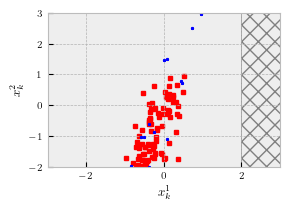

In [721]:

plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 

plt.rc( 'text', usetex=True )

x0_prime_rec = np.full((n, T_horizon), np.nan)
x0_hat_rec = np.full((n, T_horizon), np.nan)

x0_hat = mu_x0
x0_true = np.sqrt(Sigma_x0)@np.random.randn(n,1) + mu_x0
x0_true_rec=np.full((n, T_horizon), np.nan)
y1s=np.full((T_horizon, ), np.nan)
for k in range(T_horizon):
    print(k)
    x0_hat_rec[:,k] = x0_hat.squeeze()
    x0_true_rec[:,k] = x0_true.squeeze()
    x0_bar = x0_hat
    plt.plot(x0_hat[0],x0_hat[1],'sr',ms=2.5,zorder=1)
    # Construct the optimization problem over xo' and xo'':
    x0_prime = cp.Variable((n,1))
    #constraints = Constraints(F,G,K,T,S,Sigma_x,Sigma_u,x0_bar,x0_prime,uBar,xBar,N,epsilon)
    #constraints = [-S @ K @ x0_prime <= uBar + S @ K @ x0_bar]
    objective = cp.Minimize(cp.quad_form(x0_prime, A1) + 2 * x0_bar.T @ A2 @ x0_prime)
    #constraints = [T @ (x0_prime + x0_bar) <= xBar]
    constraints = []
    #for kk in range(1,N+1):
    #    constraints += [T @ Gamma(F,G,K,kk-1) @ x0_prime <= xBar-np.sqrt((1-epsilon)/epsilon)*np.sqrt(np.diag(T@Sigma_x@T.T).reshape(1,1))-T@matrix_power(F-G@K,kk)@x0_bar]
    for kk in range(1,N+1):
        A_constraints = T @ Gamma(F,G,K,kk-1)
        b_constraints = -T @ matrix_power(F-G@K,kk) @ x0_bar + \
            xBar-np.sqrt((t-epsilon)/epsilon)*np.sqrt(np.diag(T@Sigma_x@T.T).reshape(t,1))
        constraints += [A_constraints @ x0_prime <= b_constraints]


    
    #constraints += [cp.quad_form( x0_prime, I1 ) + x0_bar.T @ I2 @ x0_prime <= c - x0_bar.T @ I3 @ x0_bar]
    prob = cp.Problem(objective,constraints)#)#, constraints)
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    x0star = x0_prime.value
    #if x0_hat[1] >= 0:
    #    x0star[1] = -x0_hat[1]
    x0_prime_rec[:,k] = x0star.squeeze()
    u = - K @ (0*x0star + x0_hat)
    x0_true, y0 = x_true_update(x0_true,F,G,u,H,Sigma_w,Sigma_v)
    plt.plot(x0star[0]+x0_hat[0],x0star[1]+x0_hat[1],'*b',ms=2,zorder=2)
    x0_hat = x_hat_update(y0,F,G,H,L,x0_hat,u)
    
    #plt.plot(x0_true[0],x0_true[1],'.k')
plt.xlim([-3, 3])
plt.ylim([-2, 3]) 

plt.savefig('figs/LinearStateSelection.pdf',bbox_inches ="tight")
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7) 

plt.show()


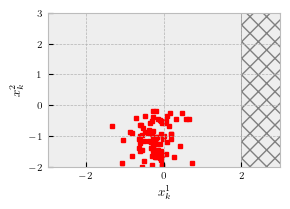

In [722]:
# Plotting
#With particle filter conditional mean
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((2,-10), 20, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)

plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$x^1_k$', fontsize=9)  
plt.ylabel('$x^2_k$', fontsize=9) 
plt.xlim([-3, 3])
plt.ylim([-2, 3])

# Initialize algorithm
Sigmapp0 = Sigma_x0
x0_hat = mu_x0
x0_true=np.sqrt(Sigma_x0)@np.random.randn(n,1)+mu_x0
y1s=np.full((T_horizon,),np.nan)
for k in range(T_horizon):
    plt.plot(x0_hat[0],x0_hat[1],'sr',ms=3,zorder=1)
    # Construct the problem.
    u = -np.array((K @ x0_hat).reshape(1,1))
    x0_true, y0 = x_true_update(x0_true,F,G,u,H,Sigma_w,Sigma_v)
    #y1s[k]=y1
    x0_hat = x_hat_update(y0,F,G,H,L,x0_hat,u)
    #plt.plot(x0_true[0],x0_true[1],'.k')

plt.savefig('figs/LinearStateSpaceLQROnly.pdf',bbox_inches ="tight")
plt.show()


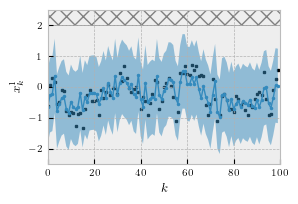

In [723]:
plt.style.use('bmh')
fig= plt.figure(figsize=(3.0,2.0))
rectangle = plt.Rectangle((-1,2), 200, 20, fc='None',ec="grey", hatch='xx',zorder=1)
plt.gca().add_patch(rectangle)
sigmas=np.sqrt(Sigma_x)[0,0]
k=range(T_horizon)
x=x0_hat_rec[0,:].reshape(T_horizon,)
nn=2
y1 = x-nn*sigmas
y2 = x+nn*sigmas

# plot
plt.xticks(fontsize=7)  
plt.yticks(fontsize=7)  
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('$x^1_k$', fontsize=9) 

plt.fill_between(k, y1, y2, alpha=.5, linewidth=0)
plt.plot(k, x, '-o', ms=1.5 , linewidth=1)
plt.plot(k,x0_true_rec[0,:],'sk',ms=2,linewidth=1,zorder=0)
plt.xlim([0, 100])
plt.ylim([-2.5, 2.5])
plt.savefig('figs/Linear2Sigmas.pdf',bbox_inches ="tight")
plt.show()